In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


In [48]:
data = pd.read_csv('amazon.csv')

data.info()

missing_values = data.isnull().sum()

data_description = data.describe()

data['discounted_price'] = data['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
data['actual_price'] = data['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)
data['discount_percentage'] = data['discount_percentage'].replace({'%': ''}, regex=True).astype(float)
data['rating'] = pd.to_numeric(data['rating'], errors='coerce')
data['rating_count'] = pd.to_numeric(data['rating_count'], errors='coerce')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

0    [1000, 5000)
1        [0, 500)
2    [1000, 5000)
3     [500, 1000)
4        [0, 500)
Name: price_bins, dtype: category
Categories (6, interval[int64, left]): [[0, 500) < [500, 1000) < [1000, 5000) < [5000, 10000) < [10000, 20000) < [20000, 50000)]


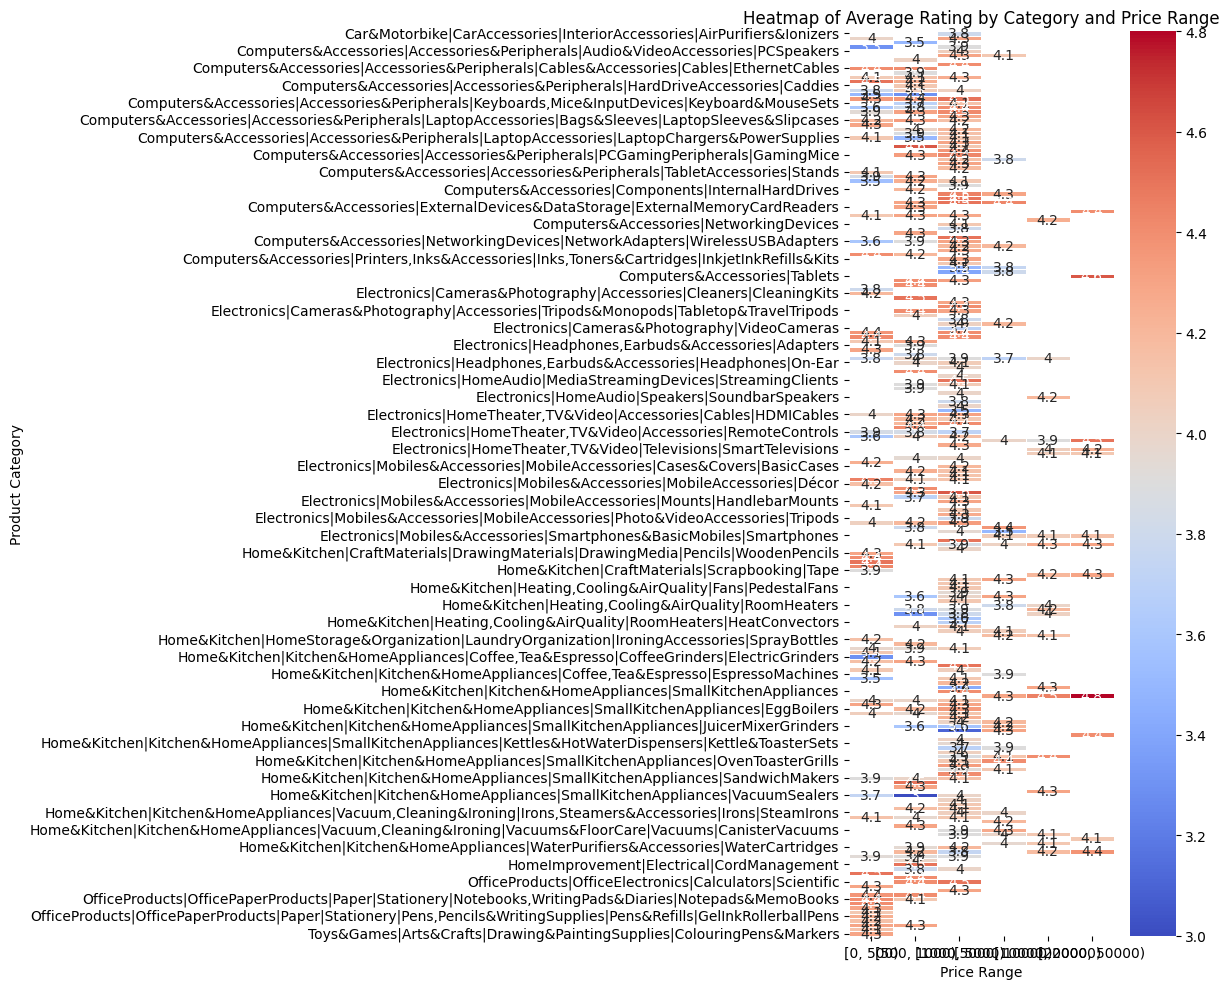

In [49]:
data_cleaned = data[['actual_price', 'rating', 'category']].dropna()

data_cleaned['price_bins'] = pd.cut(data_cleaned['actual_price'], bins=[0, 500, 1000, 5000, 10000, 20000, 50000], right=False)

print(data_cleaned['price_bins'].head())

pivot_table = data_cleaned.pivot_table(values='rating', index='category', columns='price_bins', aggfunc='mean', observed=True)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Average Rating by Category and Price Range')
plt.xlabel('Price Range')
plt.ylabel('Product Category')

plt.tight_layout()
plt.show()


# Visualizing Data Distributions

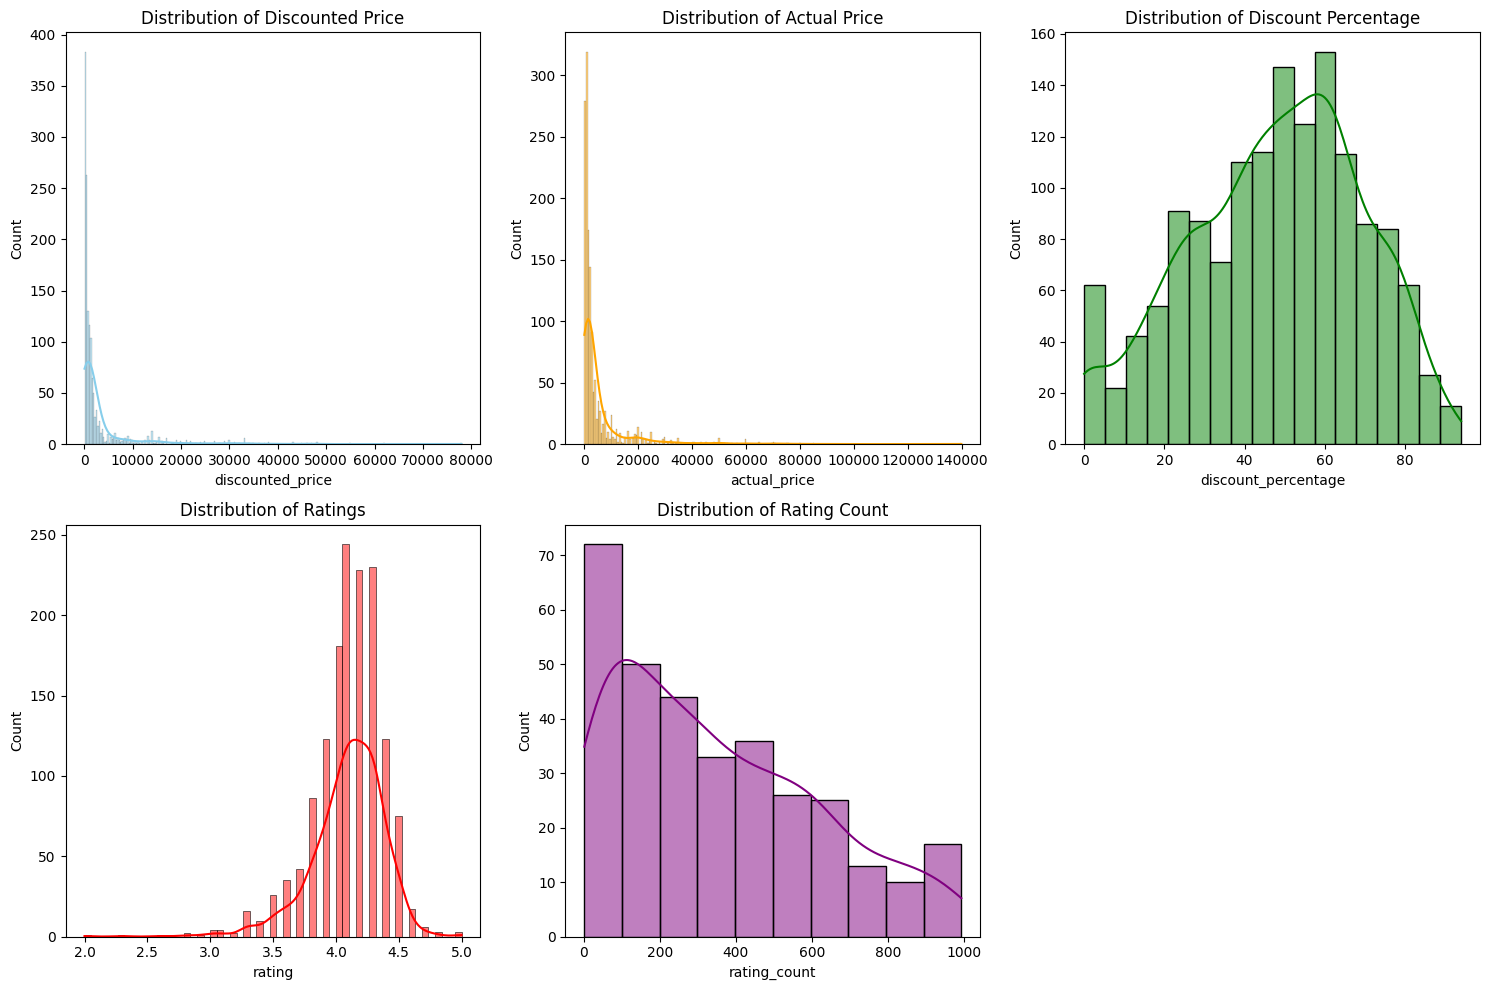

In [50]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(data['discounted_price'], kde=True, color='skyblue')
plt.title('Distribution of Discounted Price')

plt.subplot(2, 3, 2)
sns.histplot(data['actual_price'], kde=True, color='orange')
plt.title('Distribution of Actual Price')

plt.subplot(2, 3, 3)
sns.histplot(data['discount_percentage'], kde=True, color='green')
plt.title('Distribution of Discount Percentage')

plt.subplot(2, 3, 4)
sns.histplot(data['rating'], kde=True, color='red')
plt.title('Distribution of Ratings')

plt.subplot(2, 3, 5)
sns.histplot(data['rating_count'], kde=True, color='purple')
plt.title('Distribution of Rating Count')

plt.tight_layout()
plt.show()

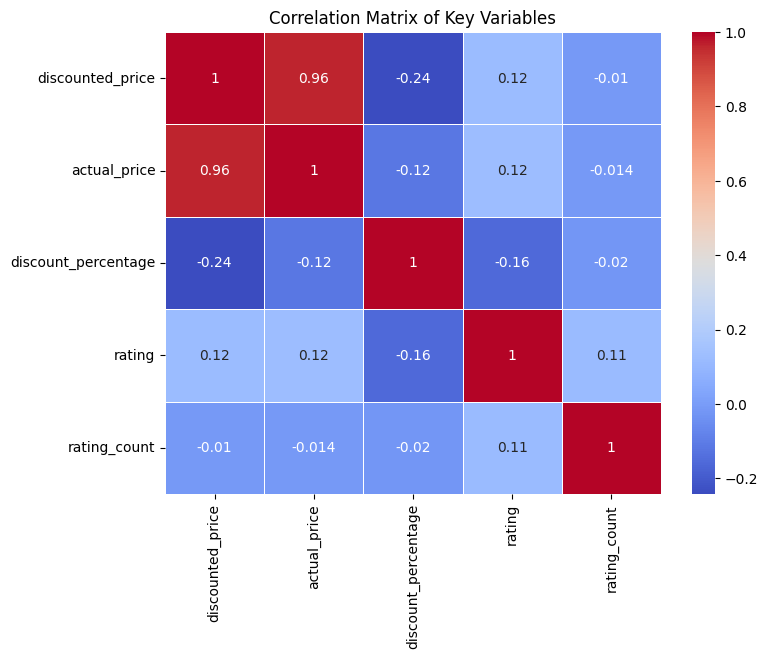

In [51]:
correlation_matrix = data[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Key Variables')
plt.show()

C:\Users\James\AppData\Local\Temp\ipykernel_8636\3141807155.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


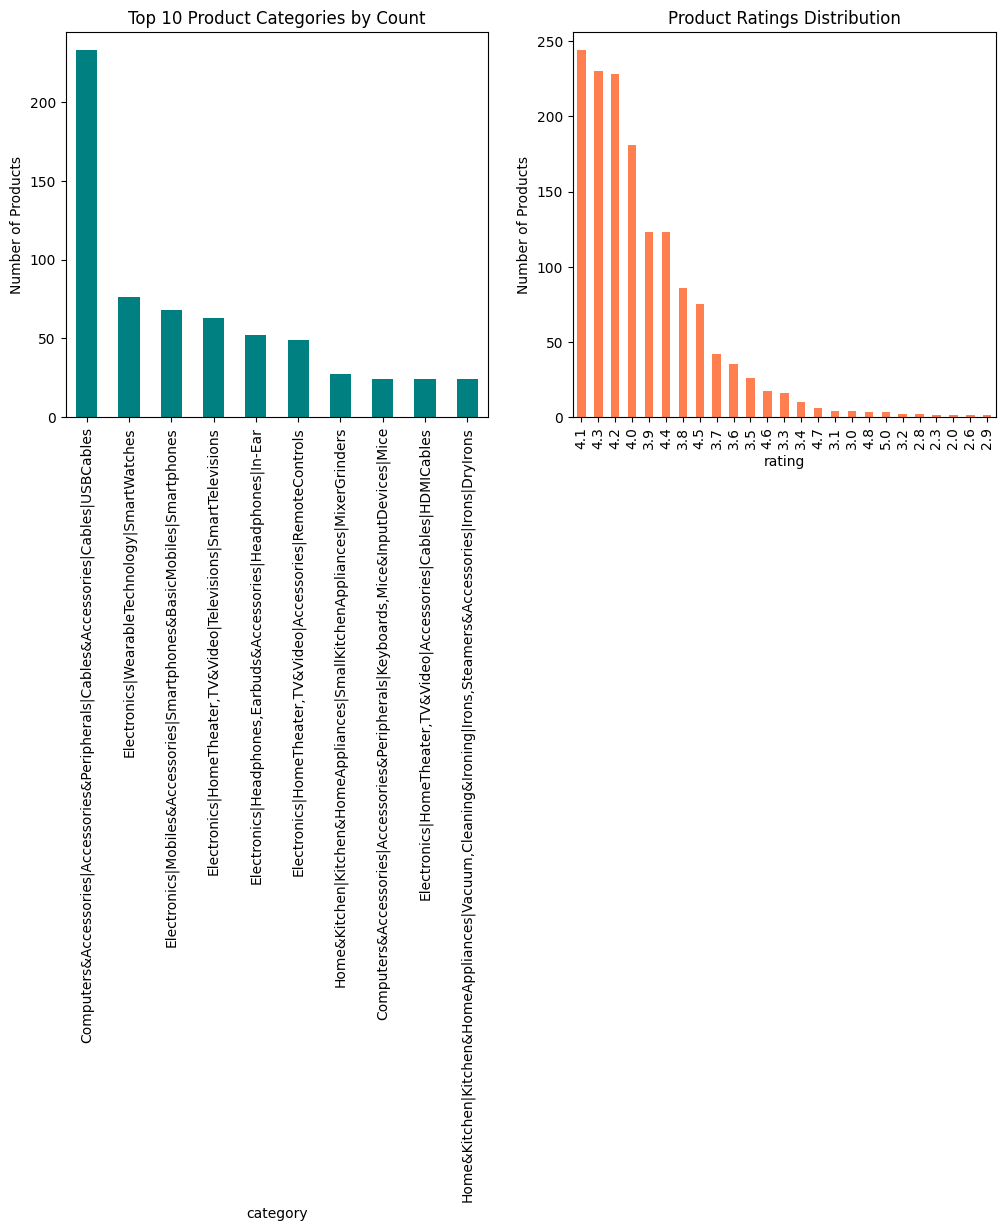

In [52]:
category_counts = data['category'].value_counts().head(10)

rating_counts = data['rating'].value_counts()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
category_counts.plot(kind='bar', color='teal')
plt.title('Top 10 Product Categories by Count')
plt.ylabel('Number of Products')

plt.subplot(1, 2, 2)
rating_counts.plot(kind='bar', color='coral')
plt.title('Product Ratings Distribution')
plt.ylabel('Number of Products')

plt.tight_layout()
plt.show()

# Box Plots to Detect Outliers

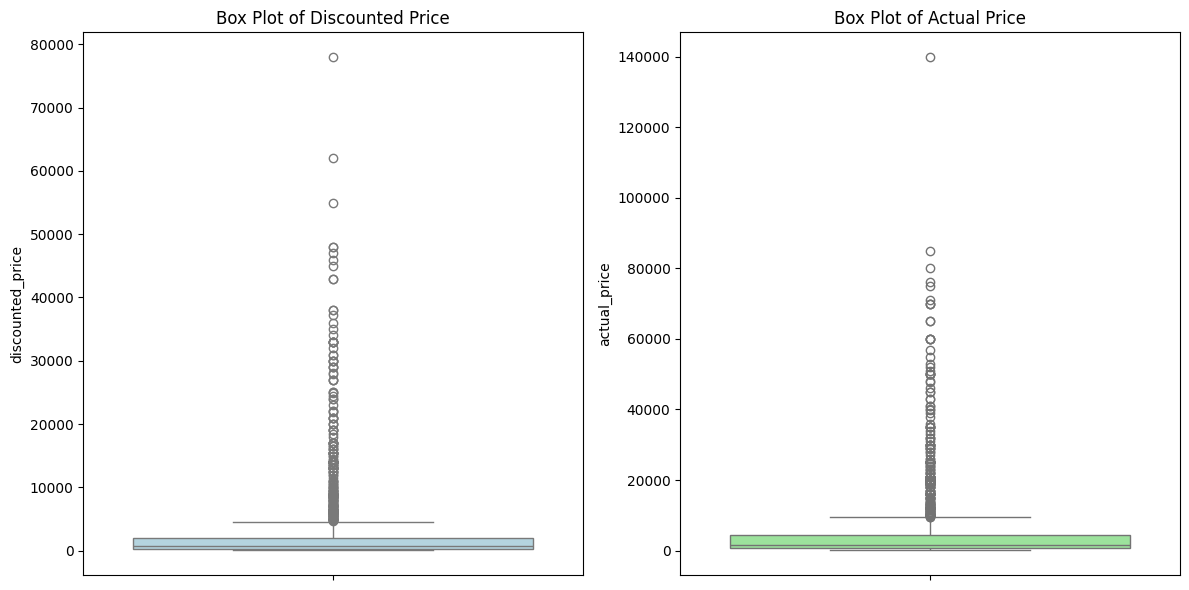

In [53]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=data, y='discounted_price', color='lightblue')
plt.title('Box Plot of Discounted Price')

plt.subplot(1, 2, 2)
sns.boxplot(data=data, y='actual_price', color='lightgreen')
plt.title('Box Plot of Actual Price')

plt.tight_layout()
plt.show()

# Pair Plot (Scatter Matrix) for Key Numerical Variables

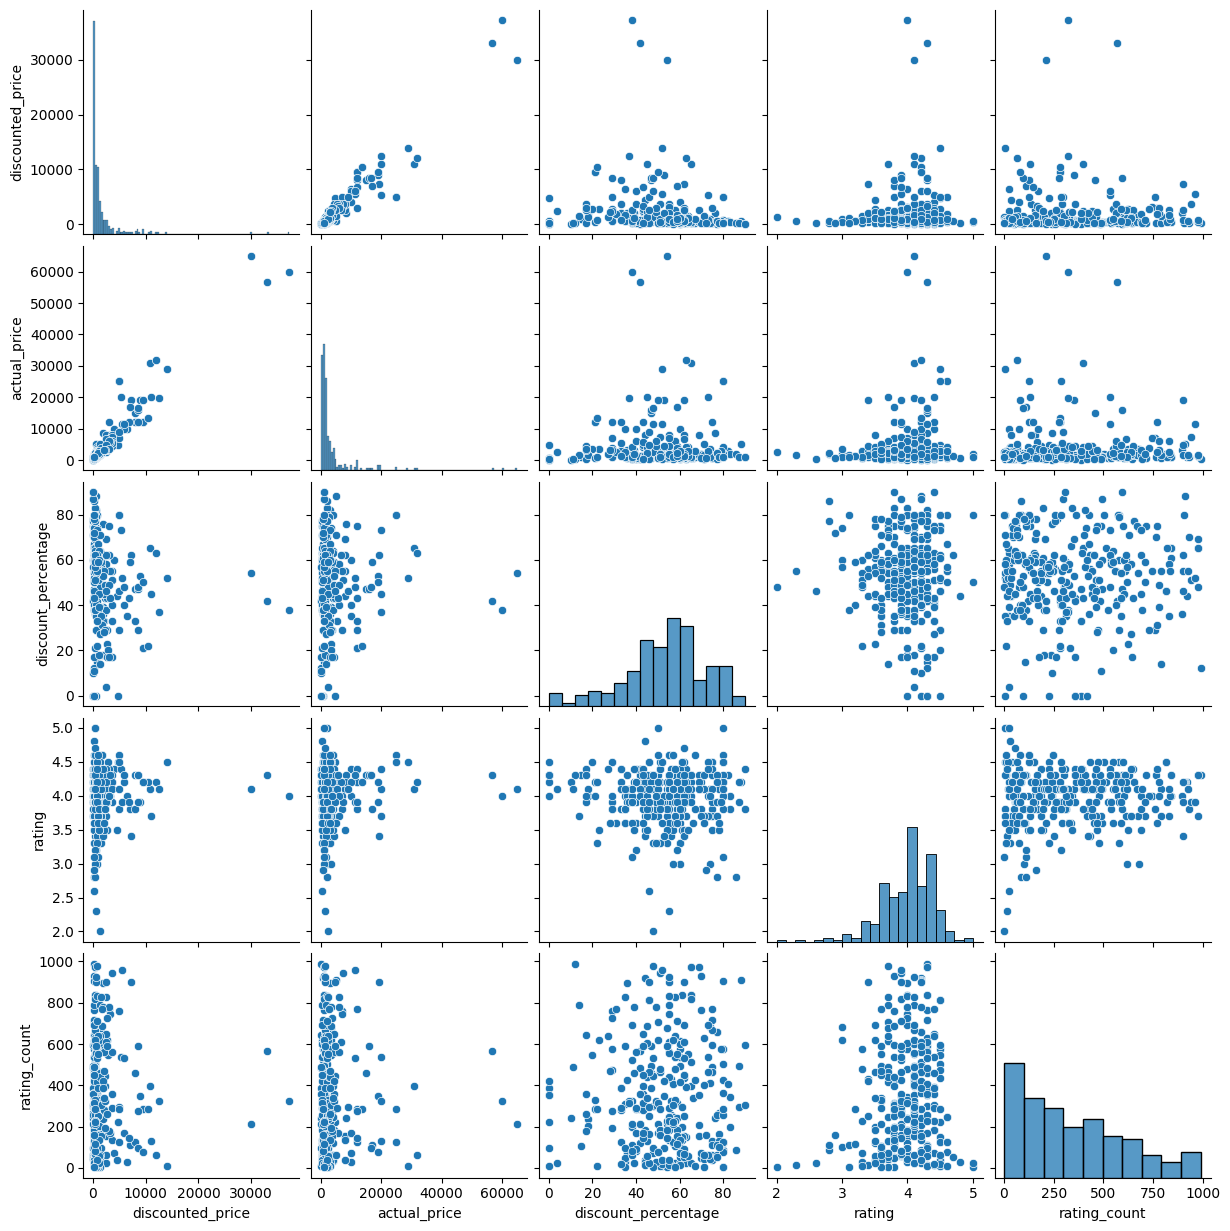

In [54]:
# Pair plot to visualize relationships between numerical variables
sns.pairplot(data[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']].dropna())
plt.show()

# Violin Plots for Ratings Across Categories

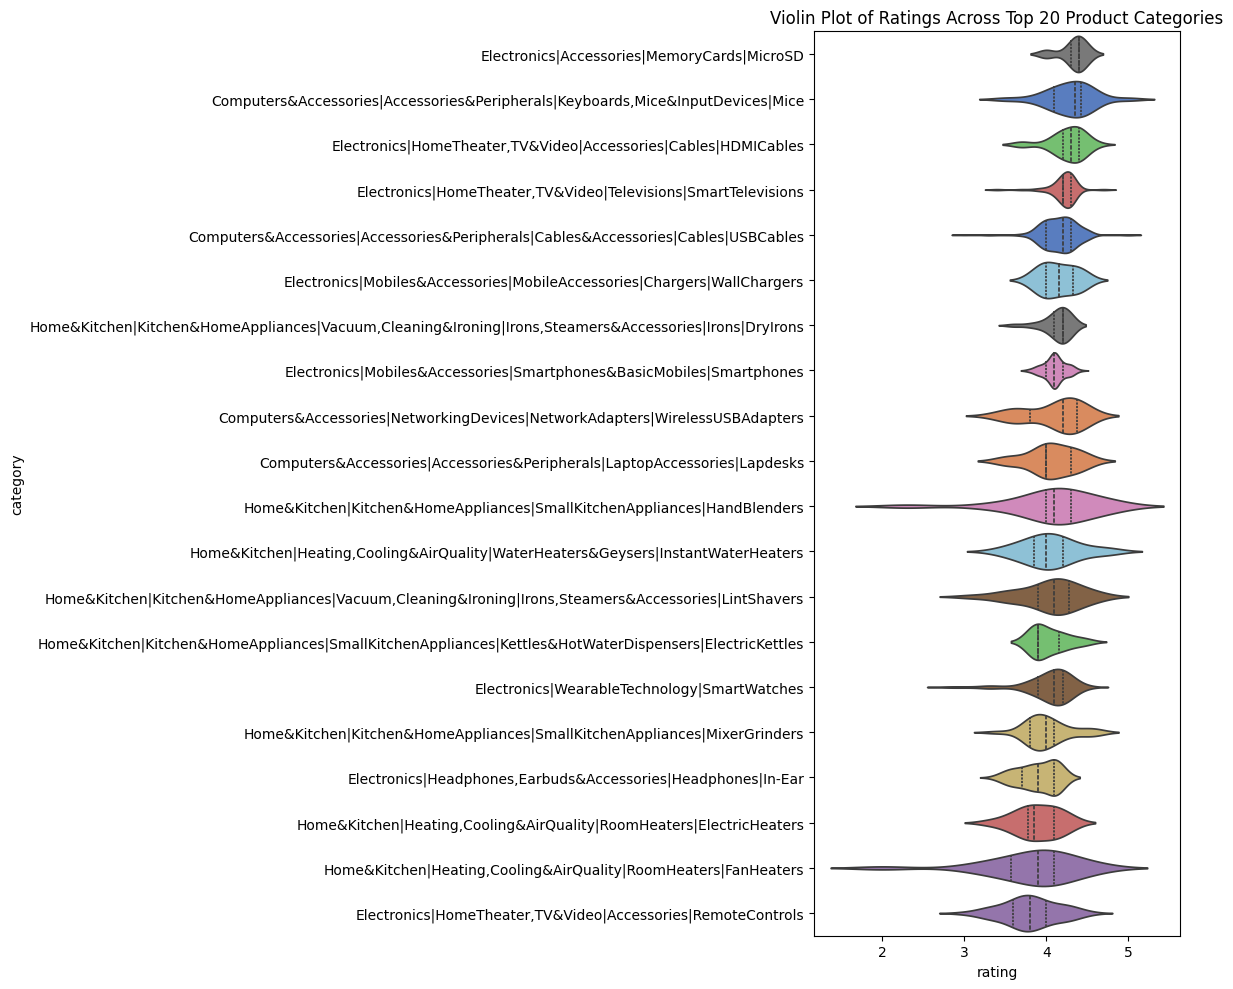

In [55]:
top_categories = data['category'].value_counts().index[:20]
filtered_data = data[data['category'].isin(top_categories)]
plt.figure(figsize=(12, 10))
sns.violinplot(x='rating', y='category', data=filtered_data, hue='category', order=filtered_data.groupby('category')['rating'].mean().sort_values(ascending=False).index, palette='muted', density_norm='width', inner='quartile', legend=False)
plt.yticks(rotation=0)

plt.title('Violin Plot of Ratings Across Top 20 Product Categories')
plt.tight_layout()
plt.show()

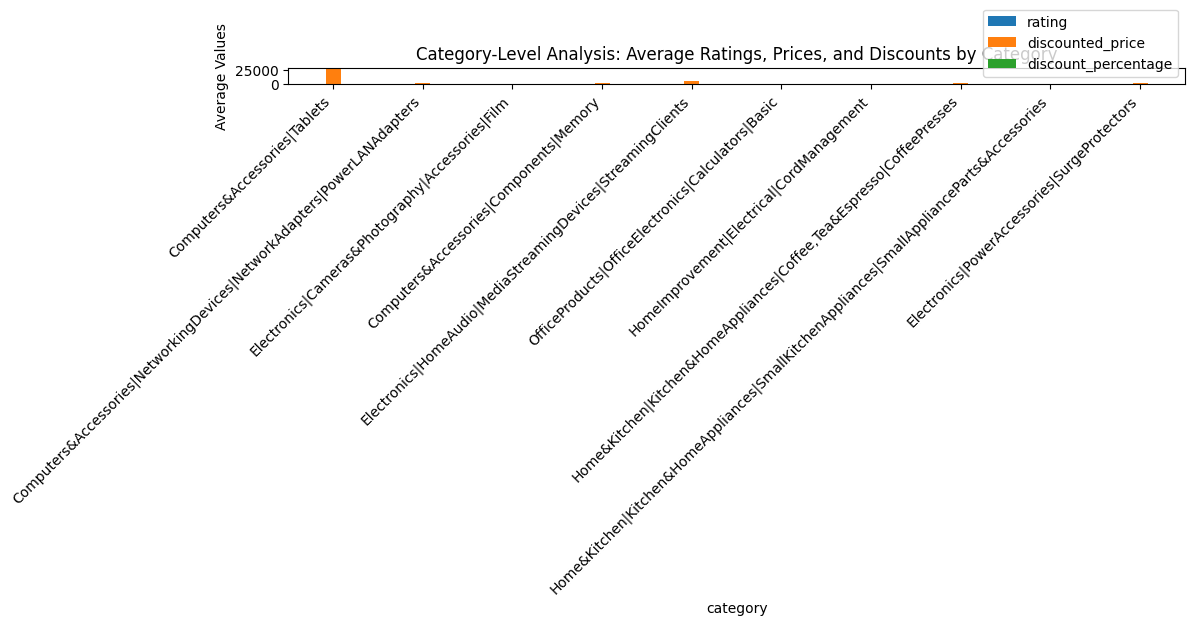

In [56]:
category_group = data.groupby('category').agg({
    'rating': 'mean',
    'discounted_price': 'mean',
    'discount_percentage': 'mean'
}).sort_values('rating', ascending=False).head(10)

category_group.plot(kind='bar', figsize=(12, 6))
plt.title('Category-Level Analysis: Average Ratings, Prices, and Discounts by Category')
plt.ylabel('Average Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sentiment Score across Reviews

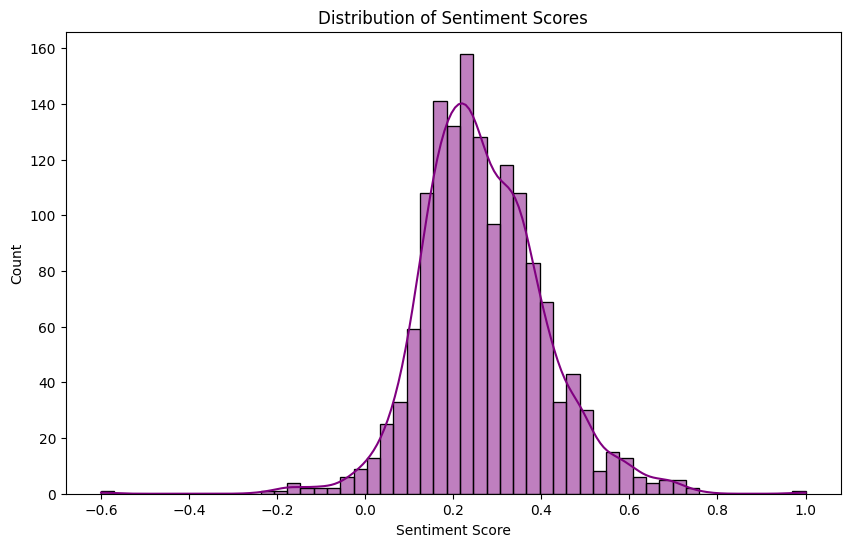

In [57]:

from textblob import TextBlob

def get_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity

data['sentiment'] = data['review_content'].apply(lambda x: get_sentiment(str(x)))

plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment'], kde=True, color='purple')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()


# Price vs. Rating: Scatter Plot

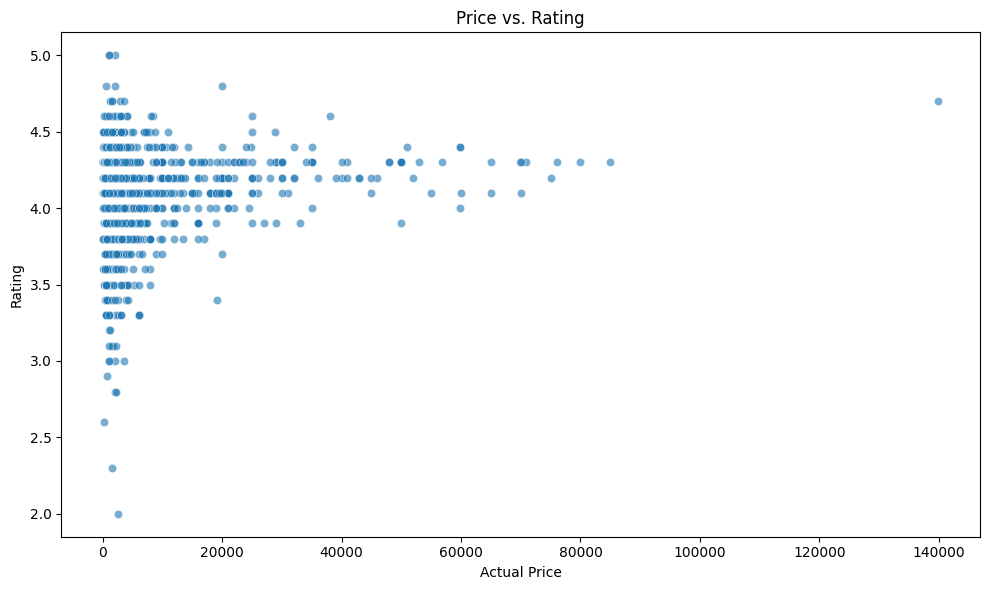

In [58]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_price', y='rating', data=data, alpha=0.6)
plt.title('Price vs. Rating')
plt.xlabel('Actual Price')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Discount Percentage vs. Rating: Scatter Plot

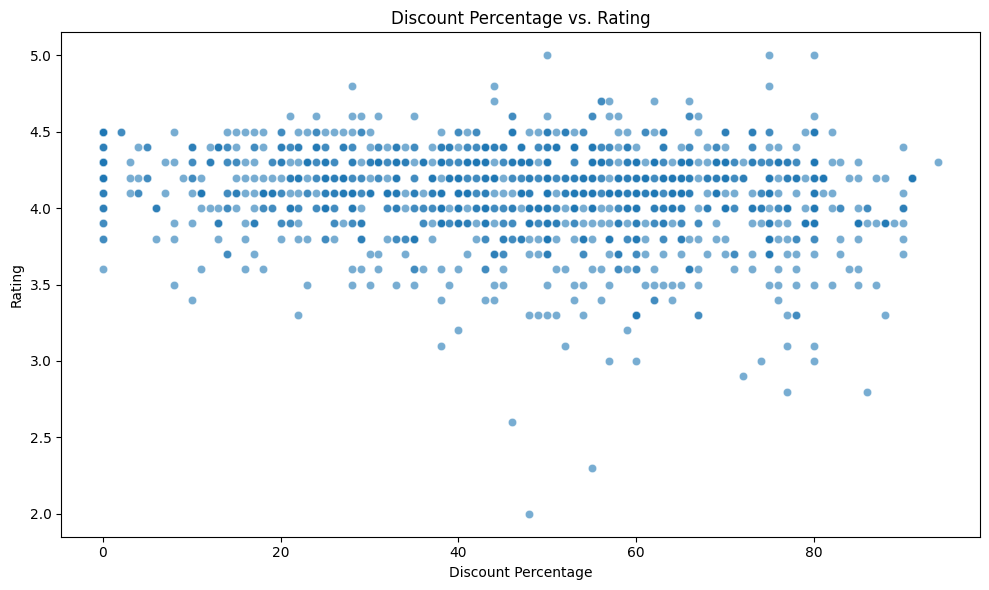

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_percentage', y='rating', data=data, alpha=0.6)
plt.title('Discount Percentage vs. Rating')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Rating Distribution by Price Ranges: Box Plot

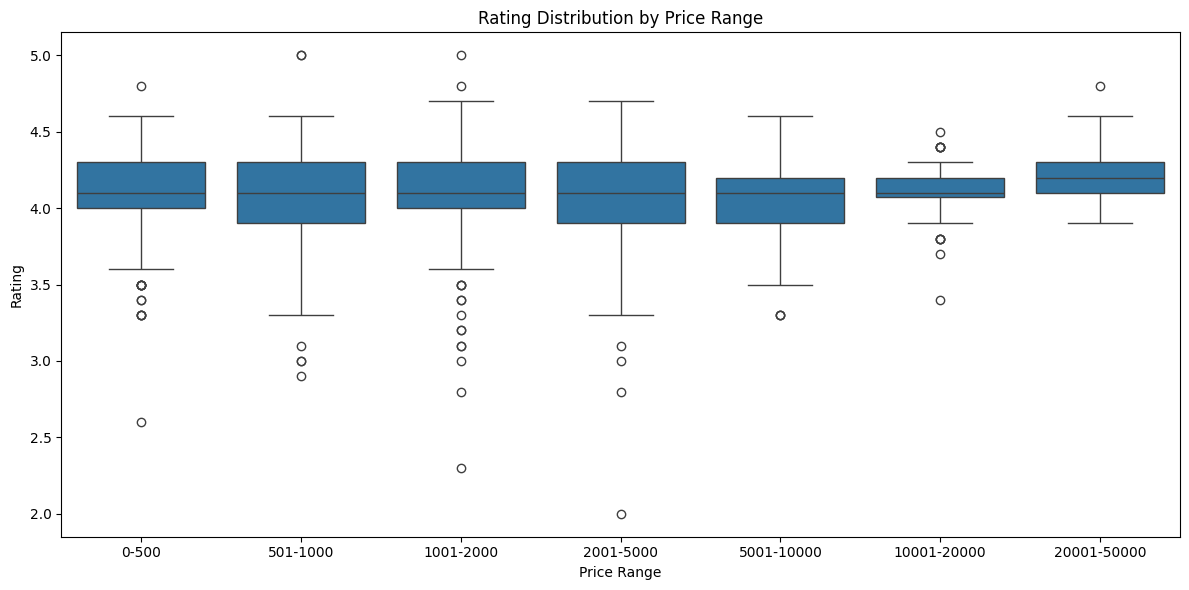

In [60]:
bins = [0, 500, 1000, 2000, 5000, 10000, 20000, 50000]
labels = ['0-500', '501-1000', '1001-2000', '2001-5000', '5001-10000', '10001-20000', '20001-50000']
data['price_range'] = pd.cut(data['actual_price'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))
sns.boxplot(x='price_range', y='rating', data=data)
plt.title('Rating Distribution by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Reviews Distribution by Rating

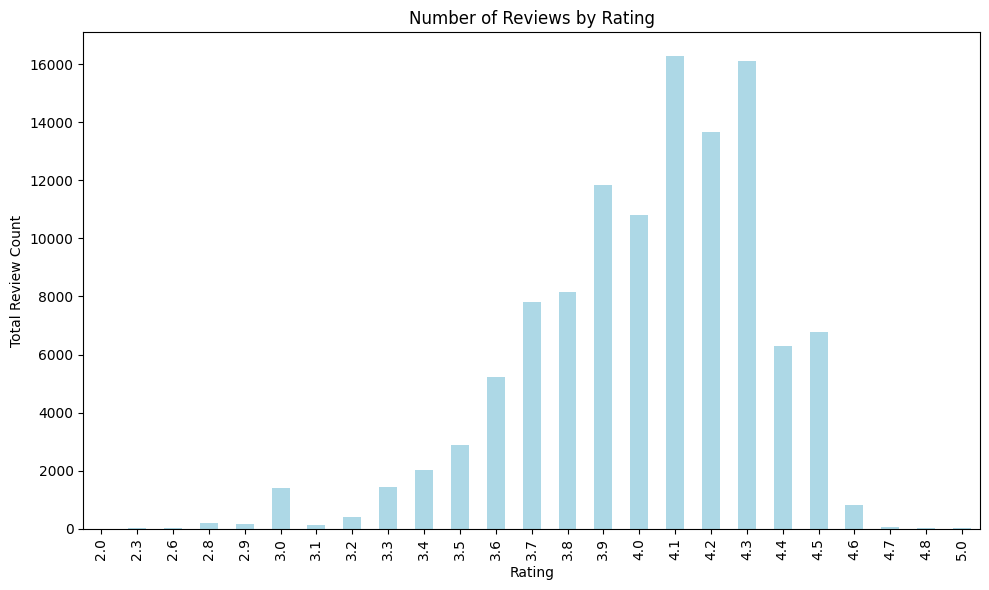

In [61]:
plt.figure(figsize=(10, 6))
rating_review_count = data.groupby('rating')['rating_count'].sum().sort_index()
rating_review_count.plot(kind='bar', color='lightblue')
plt.title('Number of Reviews by Rating')
plt.xlabel('Rating')
plt.ylabel('Total Review Count')
plt.tight_layout()
plt.show()

# Category-Wise Price Distribution: Box Plot

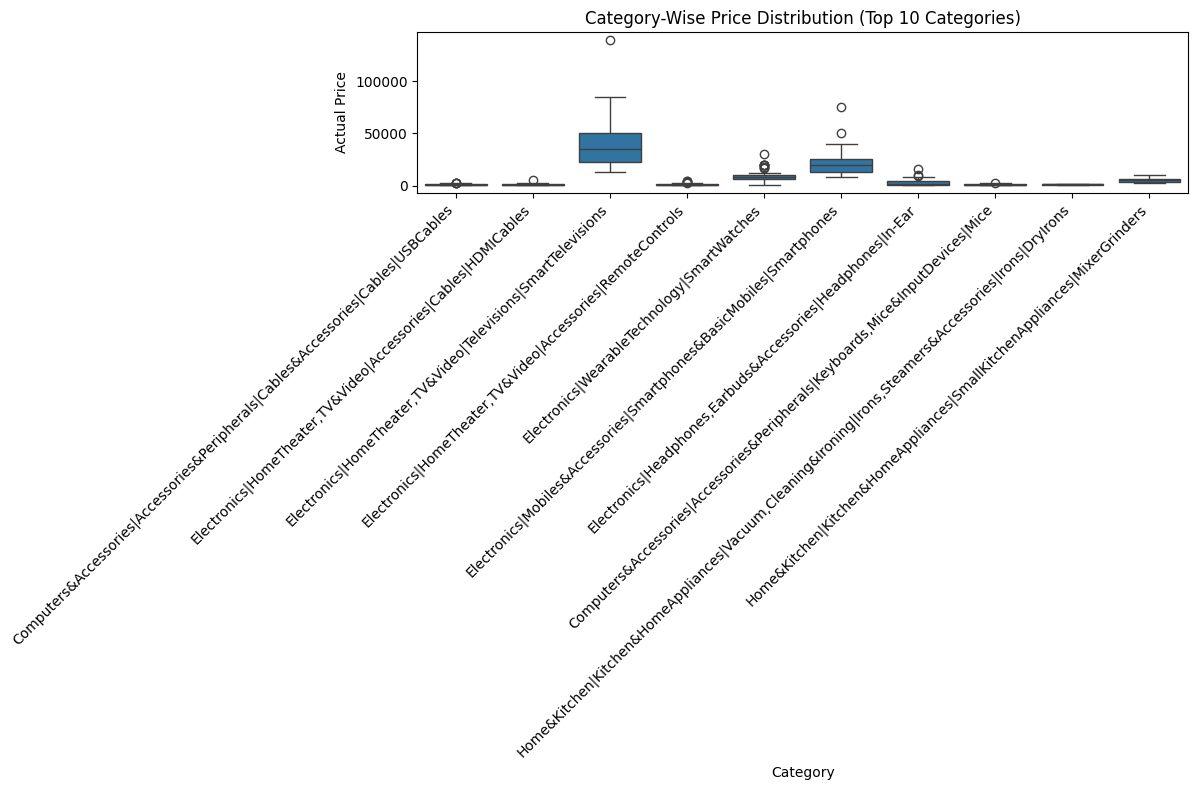

In [62]:
top_categories = data['category'].value_counts().index[:10]
filtered_data = data[data['category'].isin(top_categories)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='category', y='actual_price', data=filtered_data)
plt.title('Category-Wise Price Distribution (Top 10 Categories)')
plt.xlabel('Category')
plt.ylabel('Actual Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bivariate Analysis of Discount and Prices: Scatter Plot

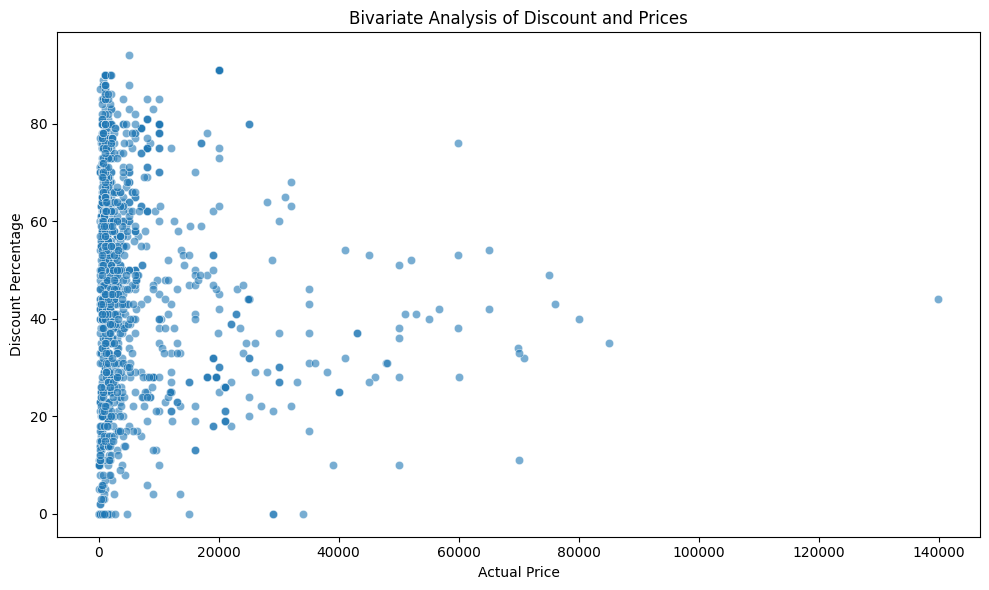

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_price', y='discount_percentage', data=data, alpha=0.6)
plt.title('Bivariate Analysis of Discount and Prices')
plt.xlabel('Actual Price')
plt.ylabel('Discount Percentage')
plt.tight_layout()
plt.show()

# Price Elasticity of Ratings: Scatter Plot

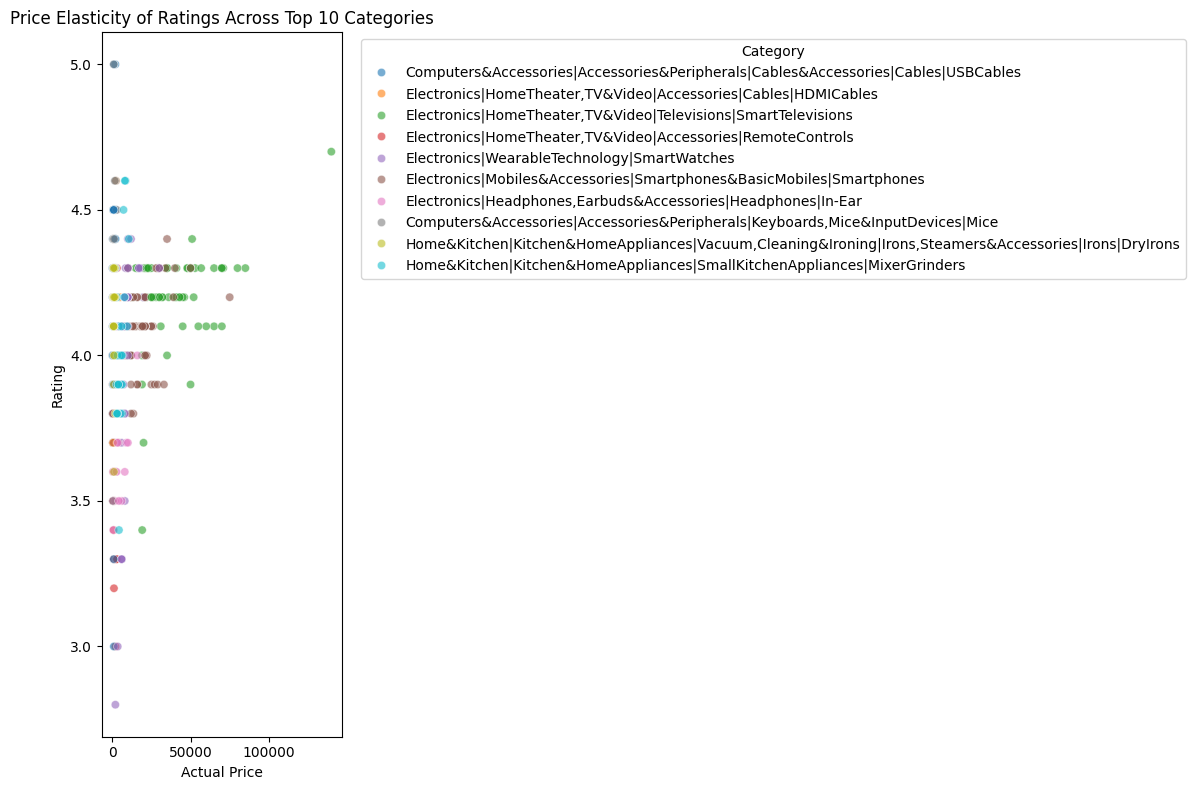

In [64]:
top_categories = data['category'].value_counts().index[:10]
filtered_data = data[data['category'].isin(top_categories)]

plt.figure(figsize=(12, 8))

sns.scatterplot(x='actual_price', y='rating', hue='category', data=filtered_data, alpha=0.6)

plt.title('Price Elasticity of Ratings Across Top 10 Categories')
plt.xlabel('Actual Price')
plt.ylabel('Rating')

plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.tight_layout()
plt.show()


# Discount Impact on Review Count: Scatter Plot

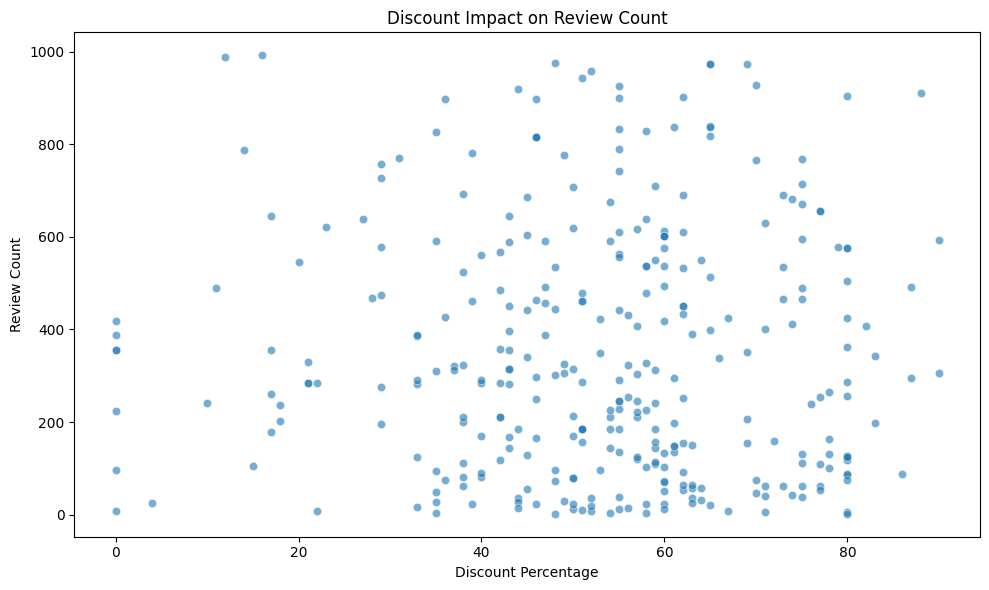

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_percentage', y='rating_count', data=data, alpha=0.6)
plt.title('Discount Impact on Review Count')
plt.xlabel('Discount Percentage')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

# Price Elasticity vs Actual Price: Scatter Plot

C:\Users\James\AppData\Local\Temp\ipykernel_8636\896834094.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['price_elasticity'] = (data['rating_count'].pct_change() / data['actual_price'].pct_change()).replace([float('inf'), -float('inf')], 0).fillna(0)


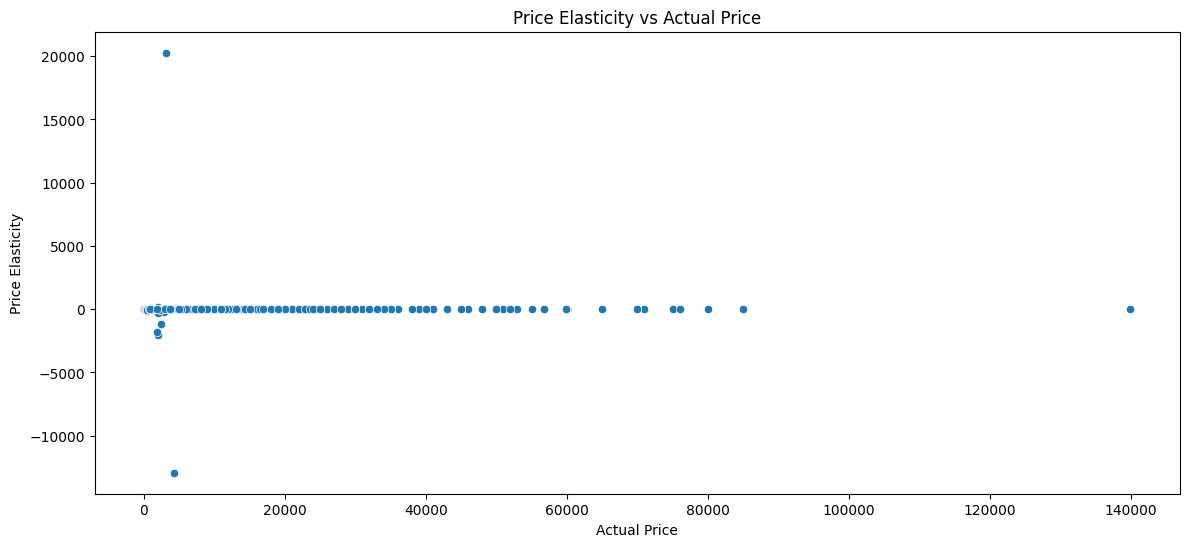

In [66]:
data['price_elasticity'] = (data['rating_count'].pct_change() / data['actual_price'].pct_change()).replace([float('inf'), -float('inf')], 0).fillna(0)

plt.figure(figsize=(14, 6))
sns.scatterplot(x='actual_price', y='price_elasticity', data=data)
plt.title('Price Elasticity vs Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Price Elasticity')
plt.show()


# Word Cloud for highly rated (4.5+) and poorly rated (below 3) products

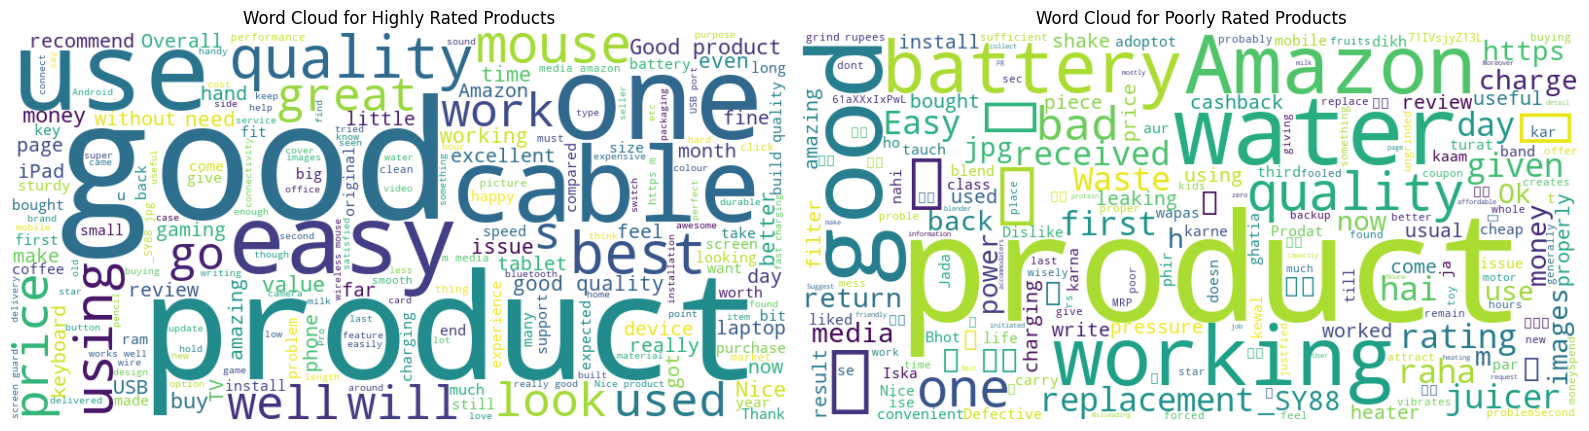

In [67]:
from wordcloud import WordCloud

high_rated_reviews = ' '.join(data[data['rating'] >= 4.5]['review_content'].dropna())
low_rated_reviews = ' '.join(data[data['rating'] < 3]['review_content'].dropna())

high_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(high_rated_reviews)
low_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(low_rated_reviews)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(high_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Highly Rated Products')

plt.subplot(1, 2, 2)
plt.imshow(low_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Poorly Rated Products')

plt.tight_layout()
plt.show()

# **Visualizing Engineered Features**

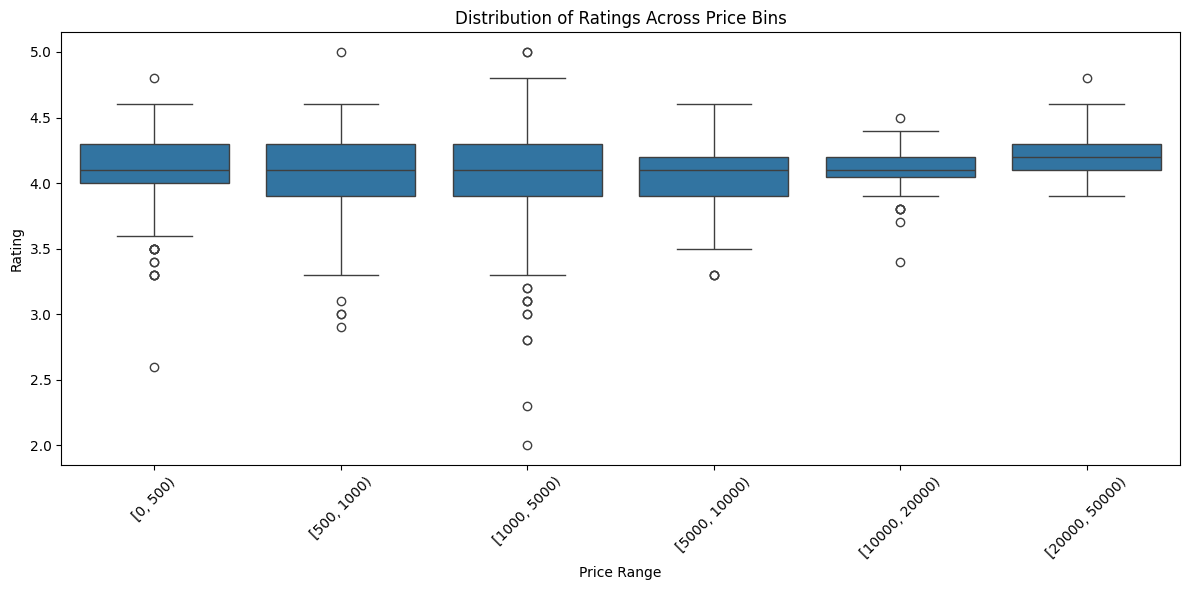

In [68]:
data['price_bins'] = pd.cut(data['actual_price'], bins=[0, 500, 1000, 5000, 10000, 20000, 50000], right=False)

plt.figure(figsize=(12, 6))
sns.boxplot(x='price_bins', y='rating', data=data)
plt.title('Distribution of Ratings Across Price Bins')
plt.xlabel('Price Range')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


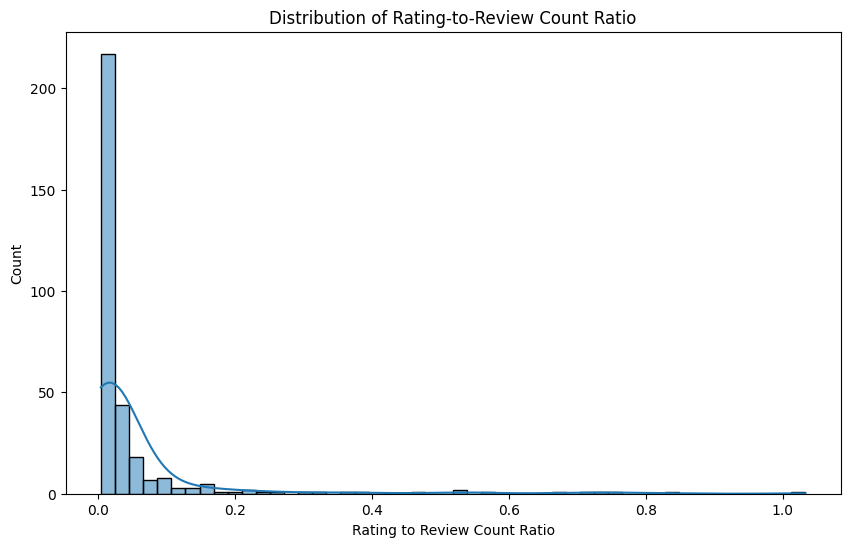

In [69]:
data['rating_to_review_count_ratio'] = data['rating'] / (data['rating_count'] + 1)

plt.figure(figsize=(10, 6))
sns.histplot(data['rating_to_review_count_ratio'], bins=50, kde=True)
plt.title('Distribution of Rating-to-Review Count Ratio')
plt.xlabel('Rating to Review Count Ratio')
plt.show()


# Category Level Aggregate Distributions

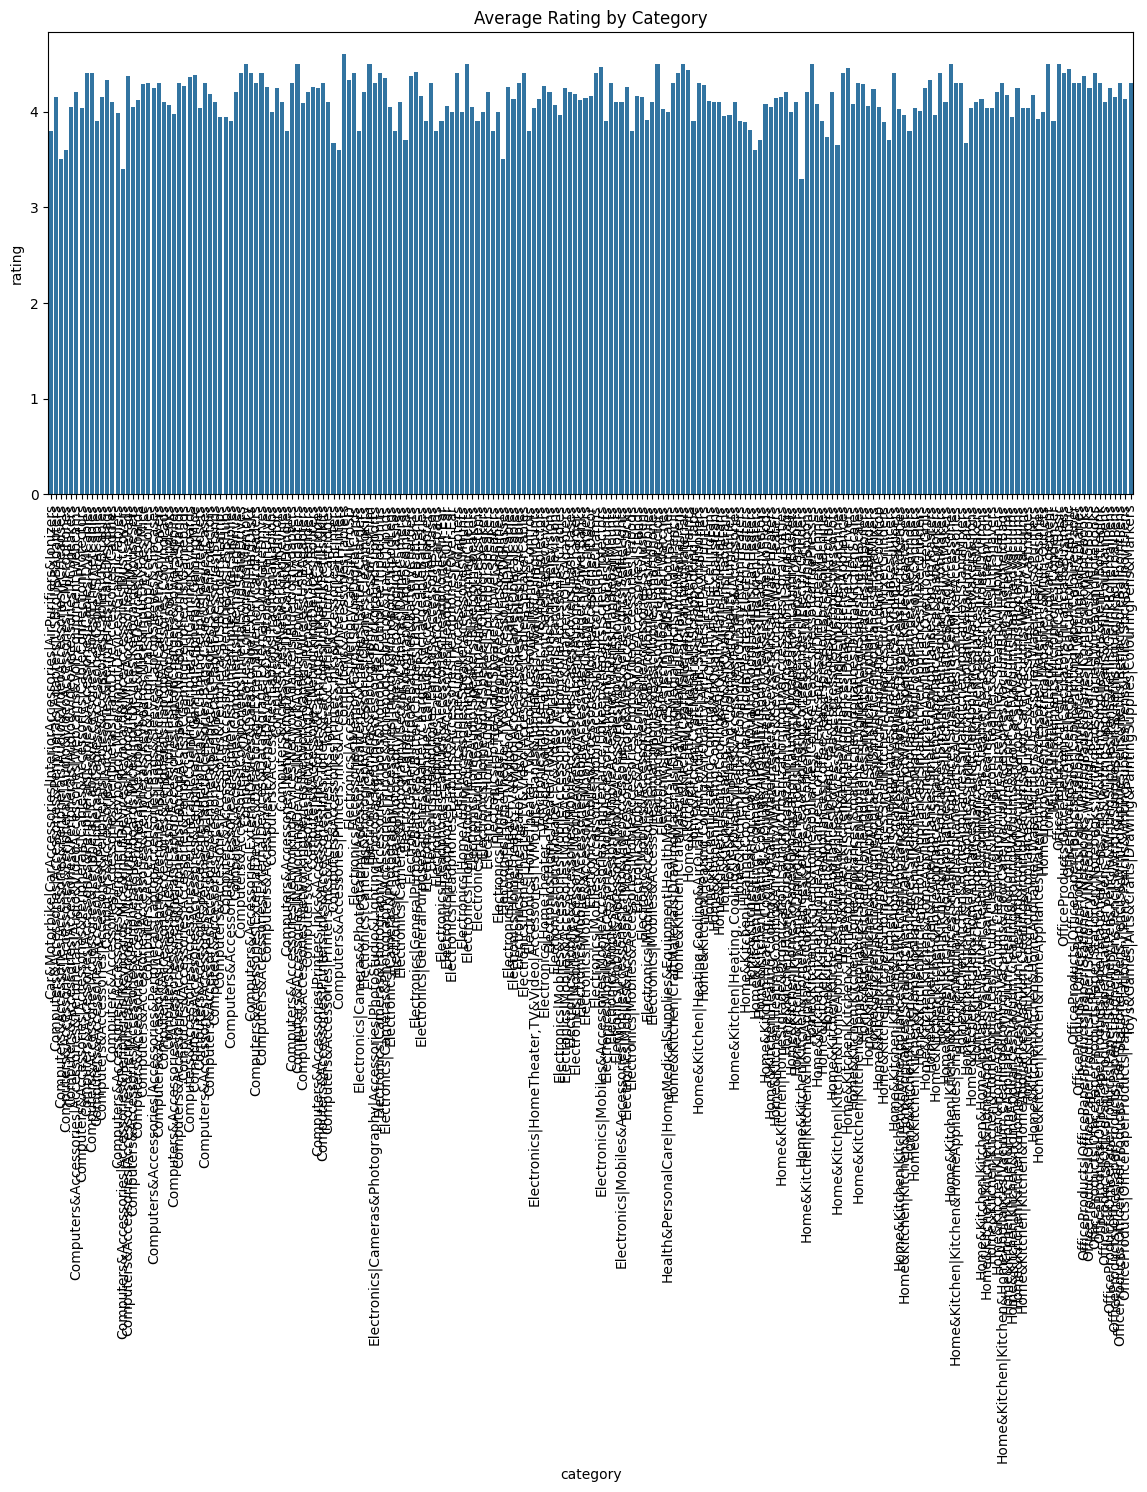

In [70]:
category_aggregates = data.groupby('category').agg({'rating': 'mean', 'actual_price': 'mean', 'discount_percentage': 'mean'}).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='category', y='rating', data=category_aggregates)
plt.title('Average Rating by Category')
plt.xticks(rotation=90)
plt.show()

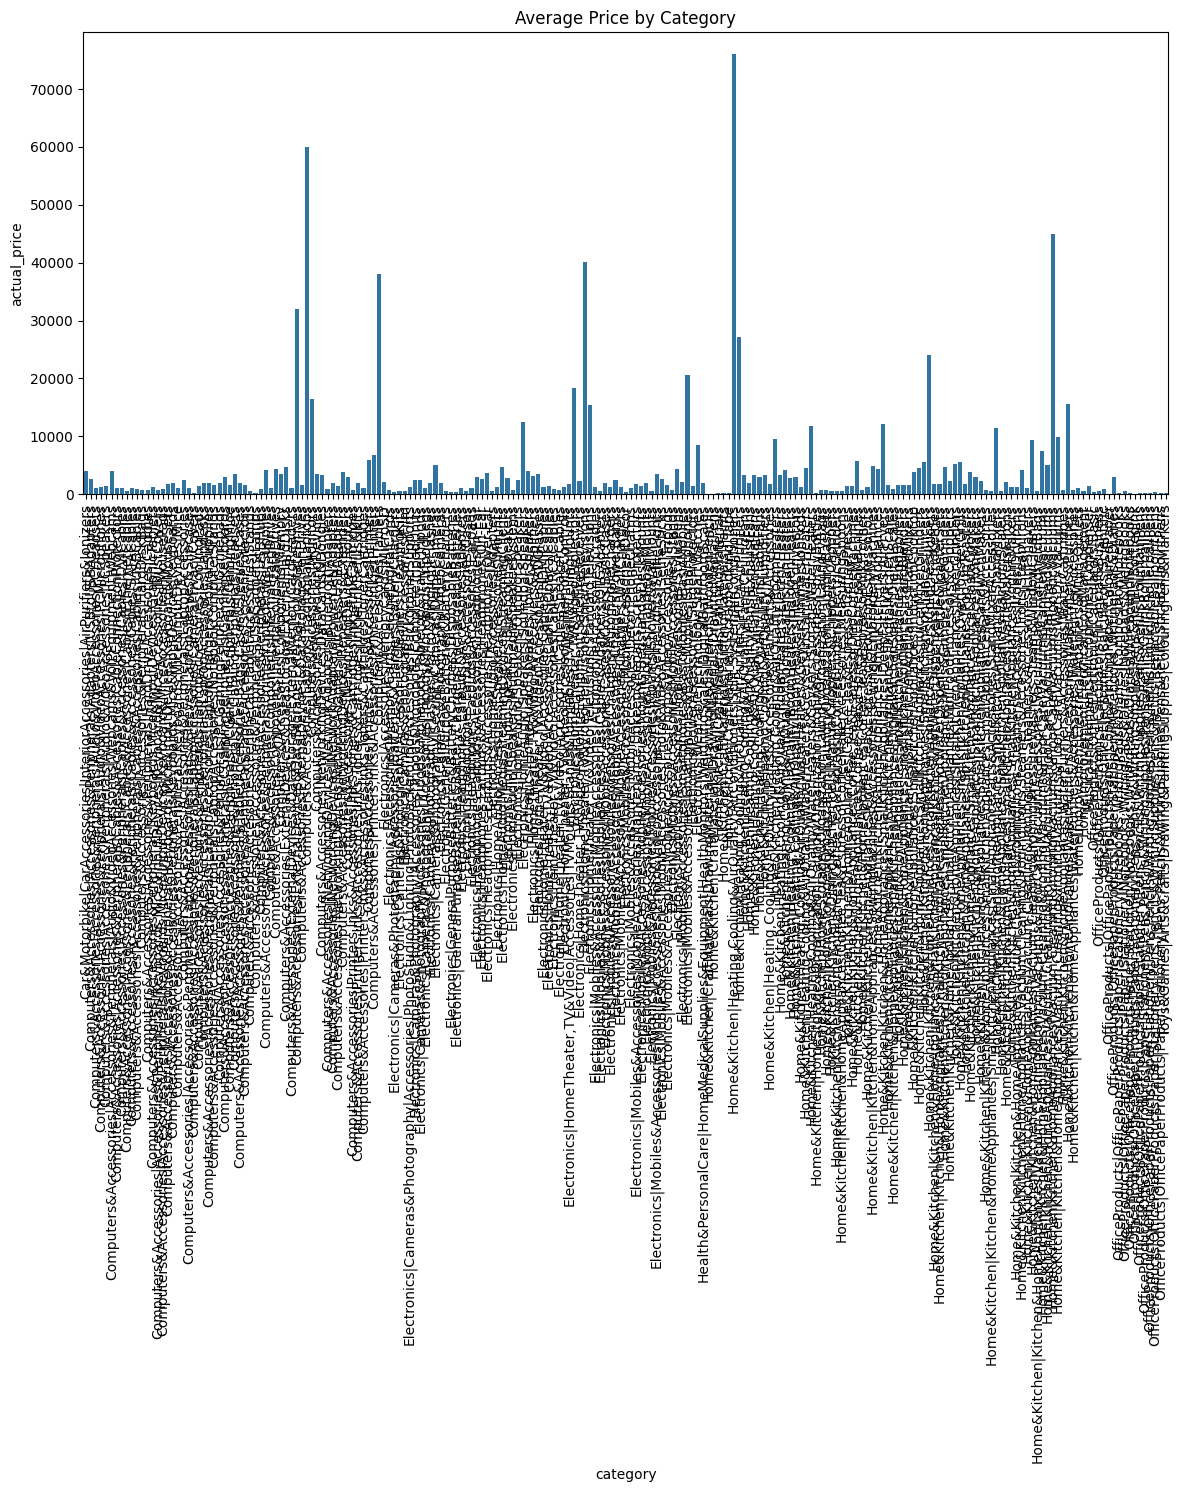

In [71]:
plt.figure(figsize=(14, 6))
sns.barplot(x='category', y='actual_price', data=category_aggregates)
plt.title('Average Price by Category')
plt.xticks(rotation=90)
plt.show()


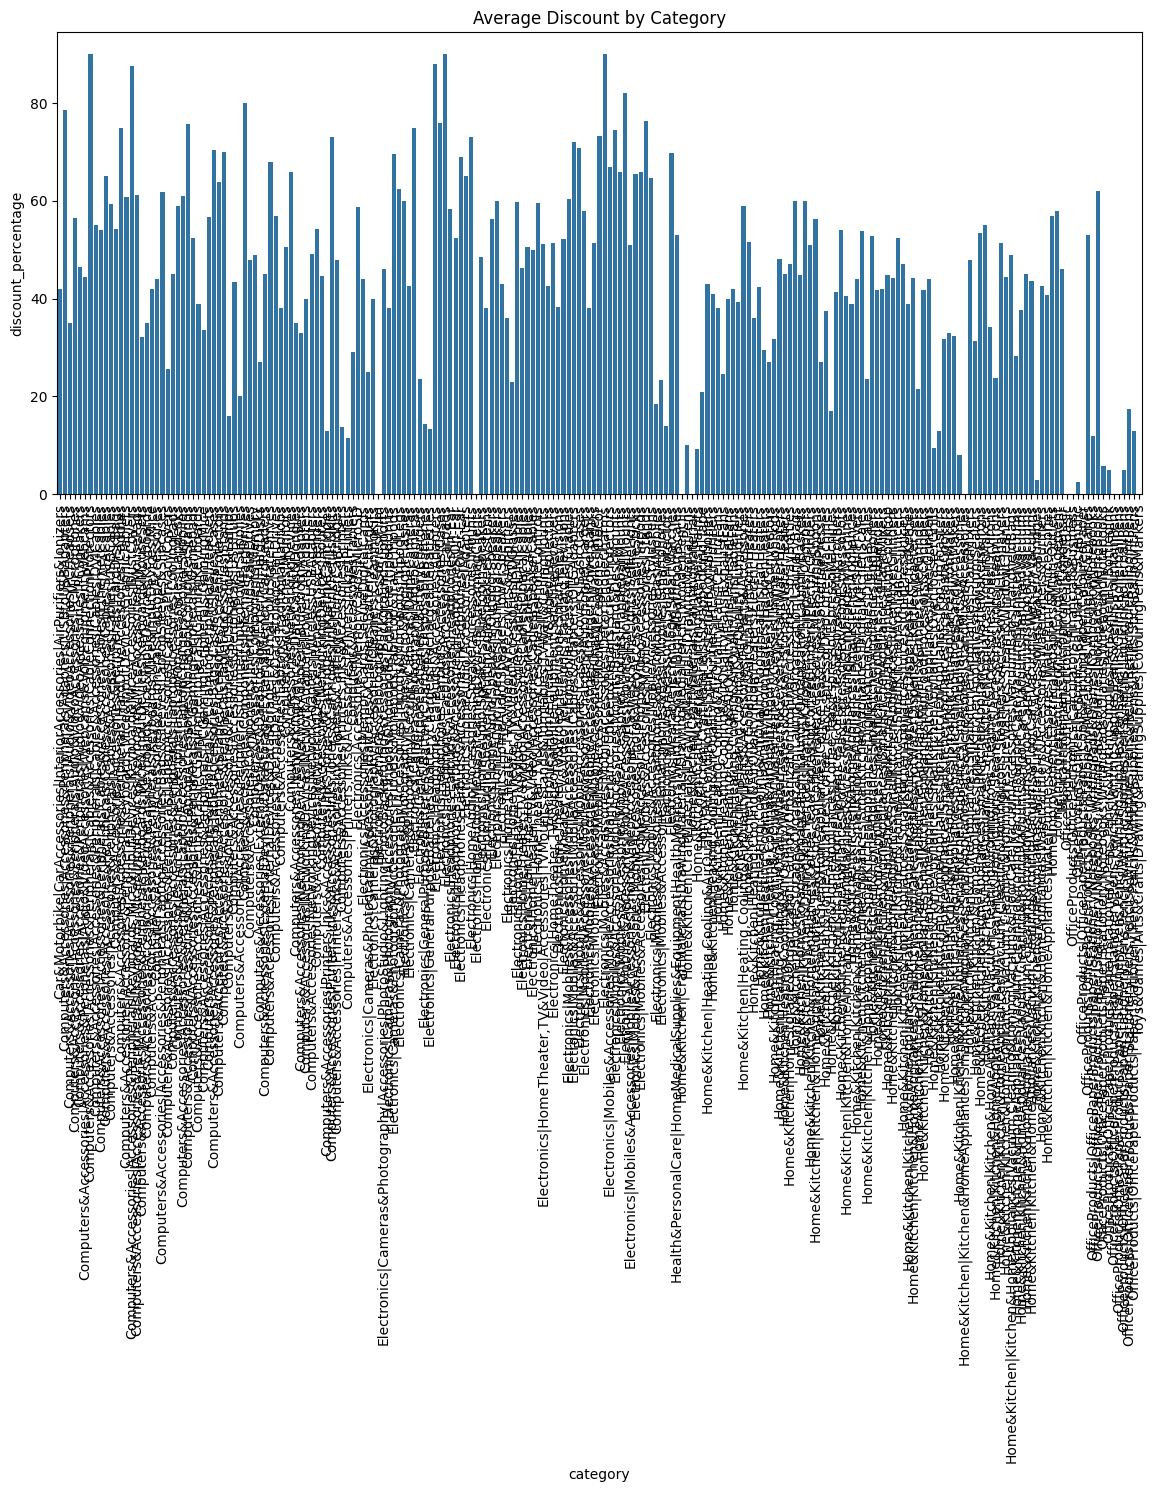

In [72]:
plt.figure(figsize=(14, 6))
sns.barplot(x='category', y='discount_percentage', data=category_aggregates)
plt.title('Average Discount by Category')
plt.xticks(rotation=90)
plt.show()


# Pair Plot (Scatter Matrix) for Key Numerical Variables

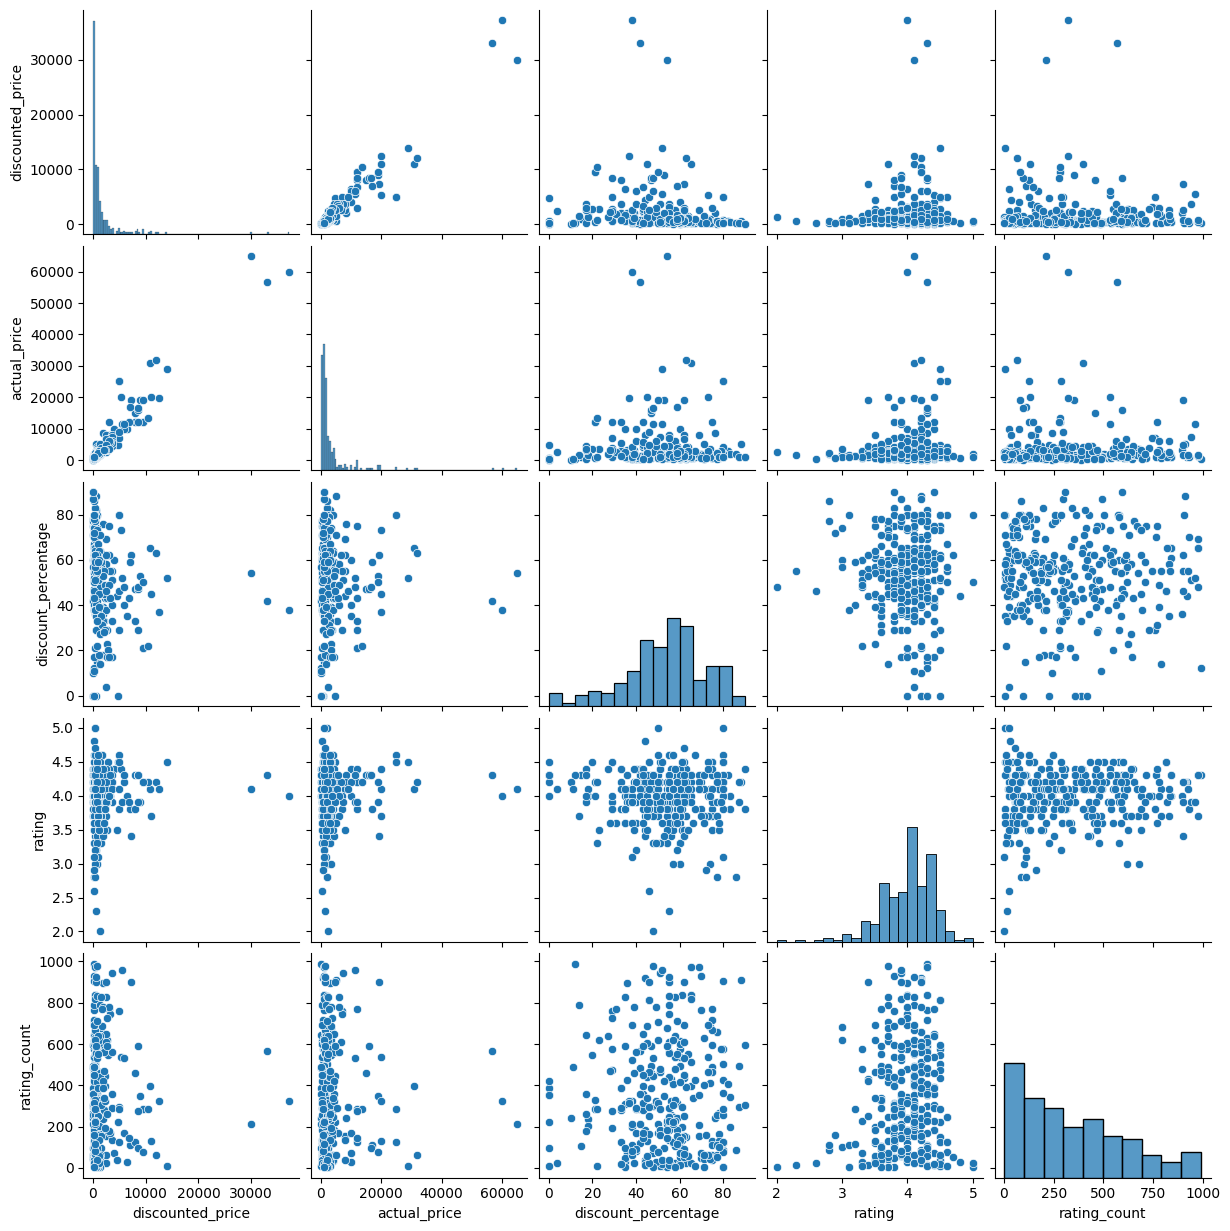

In [73]:
sns.pairplot(data[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count']].dropna())
plt.show()

# Price vs. Rating: Scatter Plot

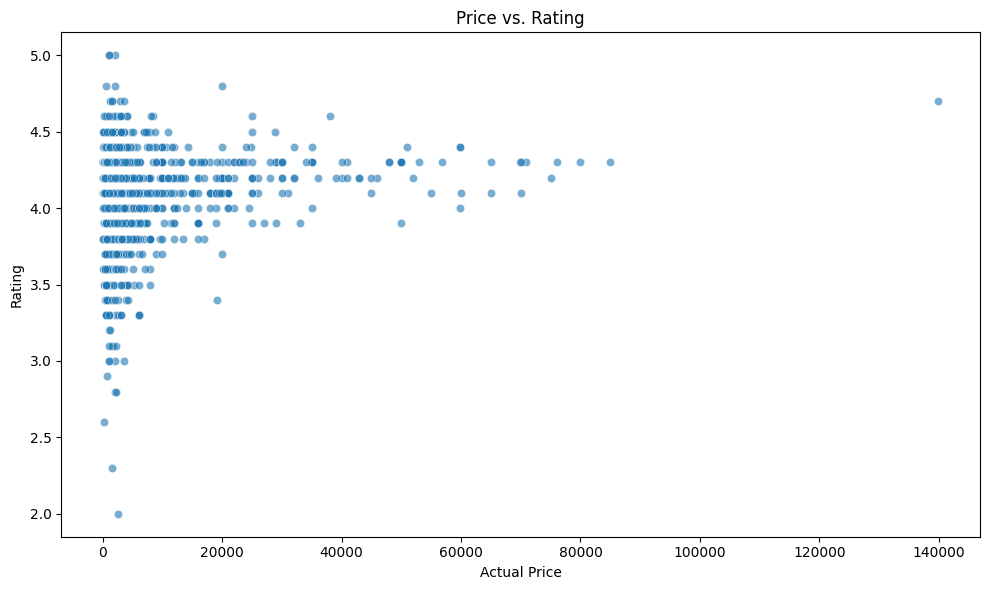

In [74]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_price', y='rating', data=data, alpha=0.6)
plt.title('Price vs. Rating')
plt.xlabel('Actual Price')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Discount Percentage vs. Rating: Scatter Plot

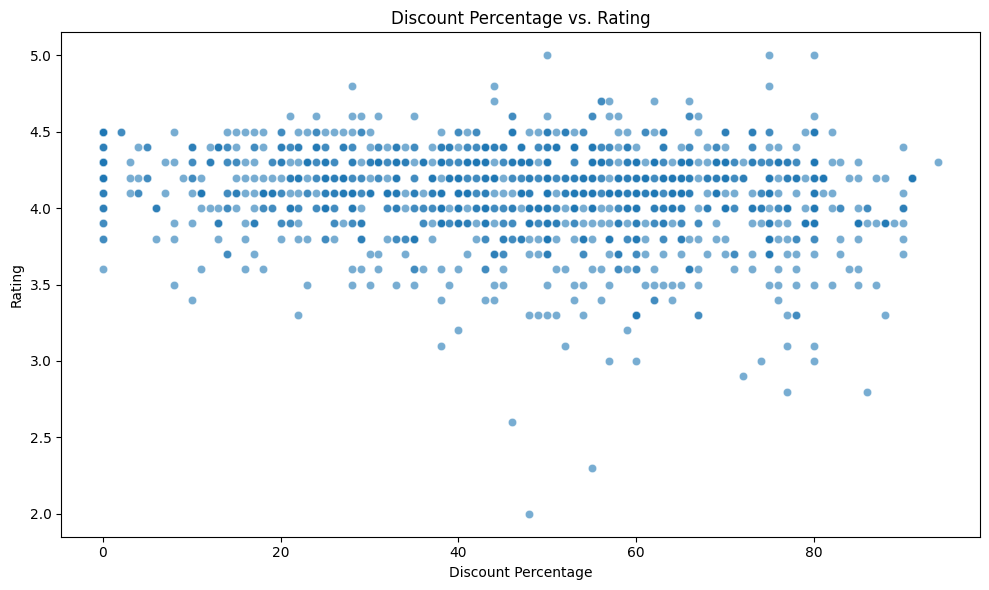

In [75]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_percentage', y='rating', data=data, alpha=0.6)
plt.title('Discount Percentage vs. Rating')
plt.xlabel('Discount Percentage')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

# Bivariate Analysis of Discount and Prices: Scatter Plot

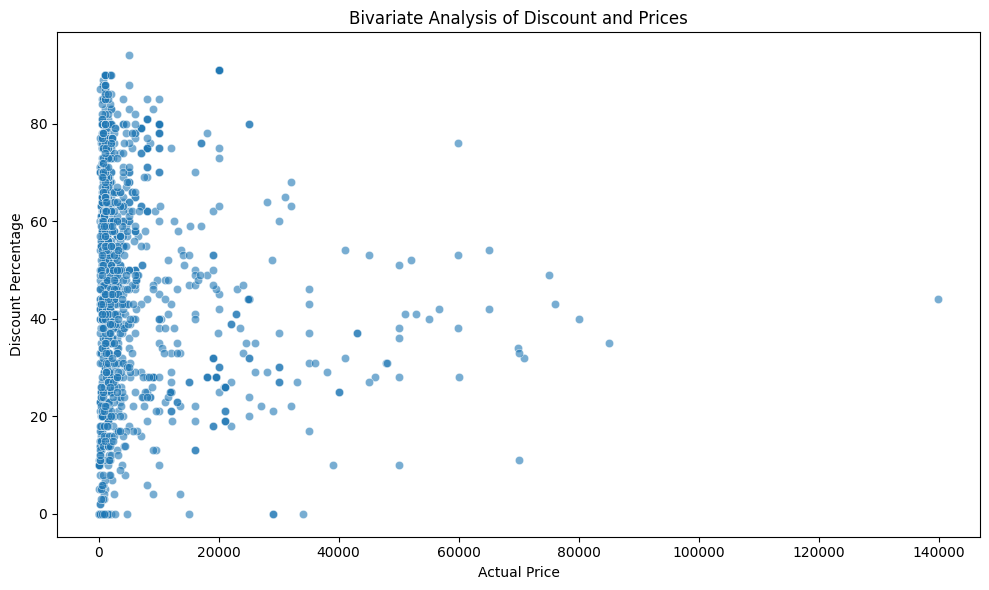

In [76]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='actual_price', y='discount_percentage', data=data, alpha=0.6)
plt.title('Bivariate Analysis of Discount and Prices')
plt.xlabel('Actual Price')
plt.ylabel('Discount Percentage')
plt.tight_layout()
plt.show()

# Price Elasticity of Ratings: Scatter Plot

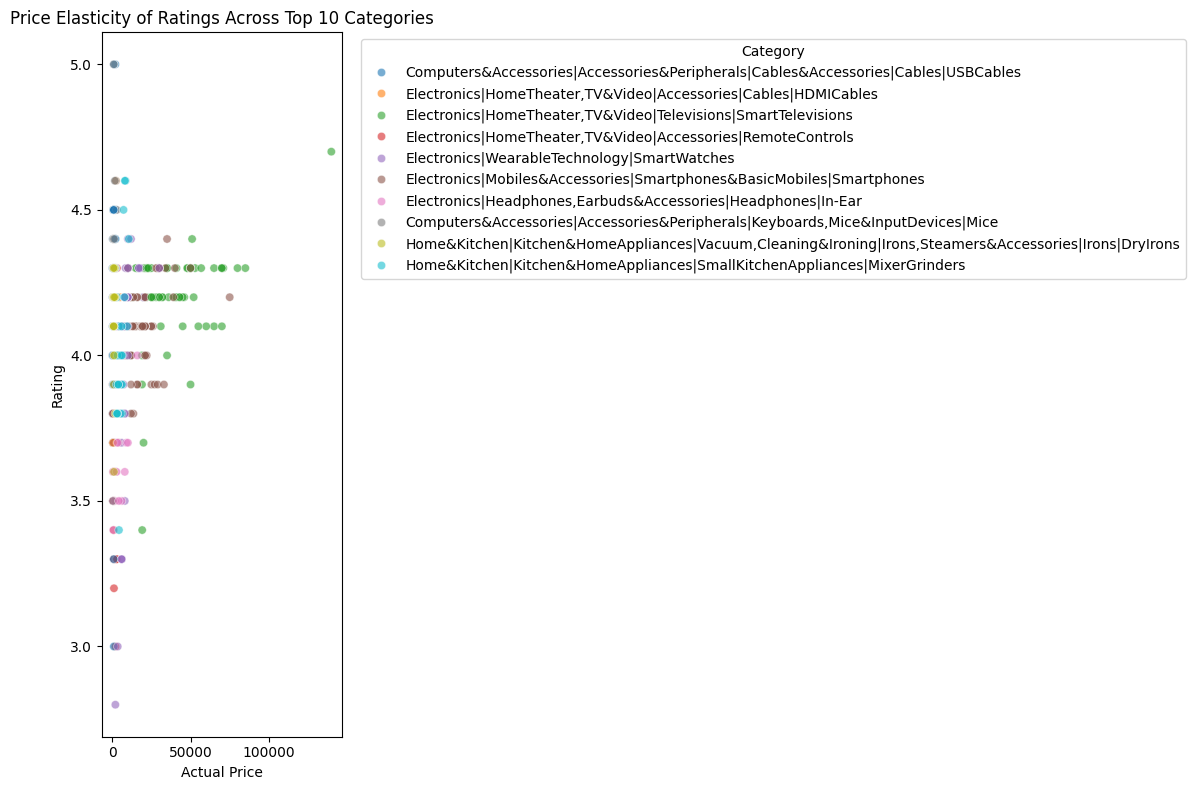

In [77]:
top_categories = data['category'].value_counts().index[:10]
filtered_data = data[data['category'].isin(top_categories)]

plt.figure(figsize=(12, 8))

sns.scatterplot(x='actual_price', y='rating', hue='category', data=filtered_data, alpha=0.6)

plt.title('Price Elasticity of Ratings Across Top 10 Categories')
plt.xlabel('Actual Price')
plt.ylabel('Rating')

plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Discount Impact on Review Count: Scatter Plot

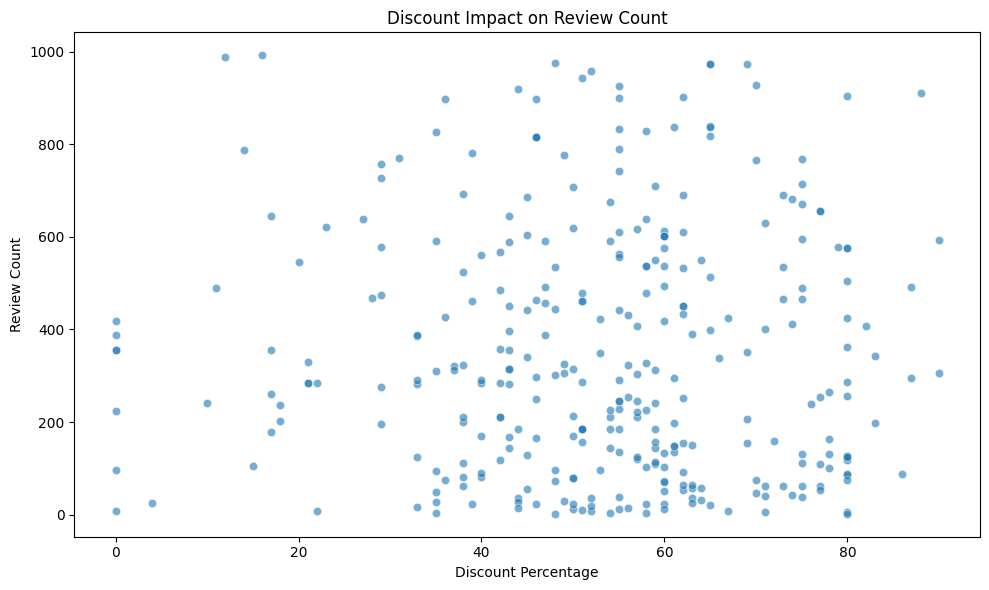

In [78]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount_percentage', y='rating_count', data=data, alpha=0.6)
plt.title('Discount Impact on Review Count')
plt.xlabel('Discount Percentage')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

C:\Users\James\AppData\Local\Temp\ipykernel_8636\896834094.py:1: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['price_elasticity'] = (data['rating_count'].pct_change() / data['actual_price'].pct_change()).replace([float('inf'), -float('inf')], 0).fillna(0)


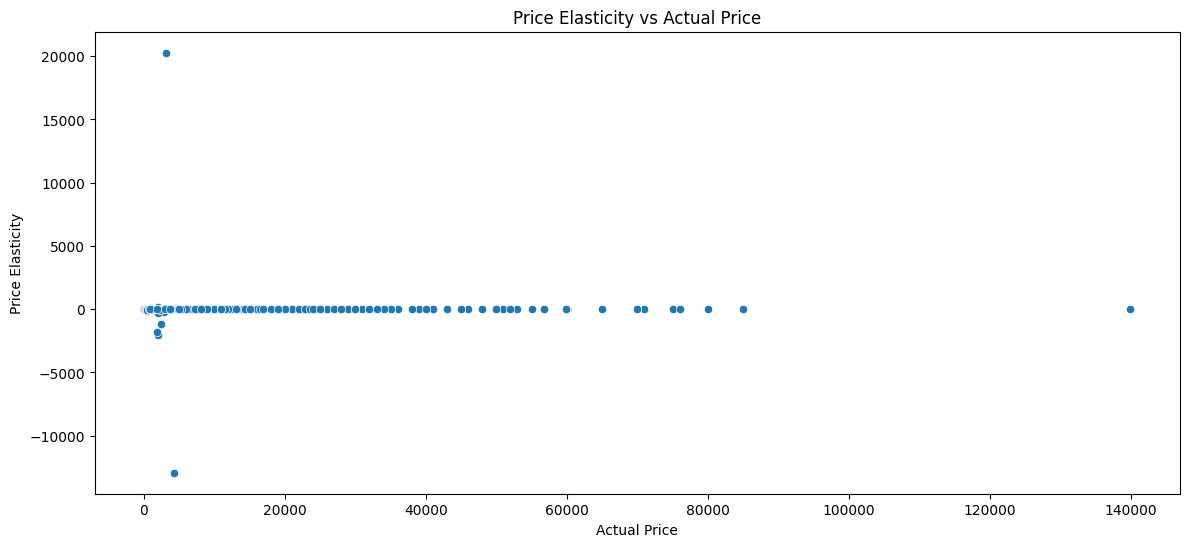

In [79]:
data['price_elasticity'] = (data['rating_count'].pct_change() / data['actual_price'].pct_change()).replace([float('inf'), -float('inf')], 0).fillna(0)

plt.figure(figsize=(14, 6))
sns.scatterplot(x='actual_price', y='price_elasticity', data=data)
plt.title('Price Elasticity vs Actual Price')
plt.xlabel('Actual Price')
plt.ylabel('Price Elasticity')
plt.show()


# Price Bins and Rating Relationship

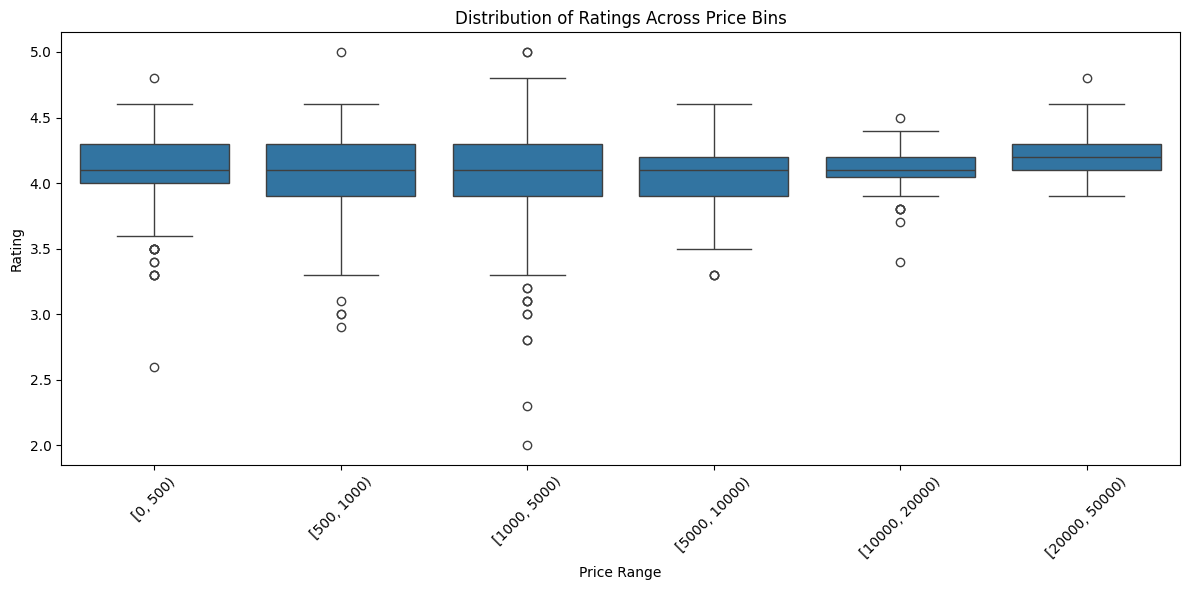

In [80]:
data['price_bins'] = pd.cut(data['actual_price'], bins=[0, 500, 1000, 5000, 10000, 20000, 50000], right=False)

plt.figure(figsize=(12, 6))
sns.boxplot(x='price_bins', y='rating', data=data)
plt.title('Distribution of Ratings Across Price Bins')
plt.xlabel('Price Range')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Model Creation


In [81]:
data['rating_count'] = data['rating_count'].replace(',', '', regex=True).astype(float)

data['rating_count'] = data['rating_count'].fillna(data['rating_count'].median())

num_bins = 3
bins = pd.qcut(data['rating_count'], q=num_bins, duplicates='drop')
labels = [f'Bin{i+1}' for i in range(len(bins.cat.categories))]
data['rating_count_bin'] = pd.qcut(data['rating_count'], q=num_bins, labels=labels, duplicates='drop')

label_encoder = LabelEncoder()
data['rating_count_bin_encoded'] = label_encoder.fit_transform(data['rating_count_bin'])

features = data[['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'category', 'sentiment']].copy()
target = data['rating_count_bin_encoded']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['discounted_price', 'actual_price', 'discount_percentage', 'rating', 'sentiment']),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), ['category'])
    ])

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)

    print(f"Model: {model.__class__.__name__}")
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n" + "="*50 + "\n")

models = [
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    SVC(kernel='rbf', random_state=42),
    KNeighborsClassifier(n_neighbors=5),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(random_state=42),
    GaussianNB(),
    MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    LGBMClassifier(boosting_type='gbdt', random_state=42)
]

for model in models:
    evaluate_model(model, X_train, X_test, y_train, y_test)

C:\Users\James\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\James\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\James\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\

Model: LogisticRegression
Accuracy Score: 0.9044368600682594

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       264
           1       1.00      0.03      0.07        29

    accuracy                           0.90       293
   macro avg       0.95      0.52      0.51       293
weighted avg       0.91      0.90      0.86       293


Confusion Matrix:
 [[264   0]
 [ 28   1]]


Model: SVC
Accuracy Score: 0.9010238907849829

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       264
           1       0.00      0.00      0.00        29

    accuracy                           0.90       293
   macro avg       0.45      0.50      0.47       293
weighted avg       0.81      0.90      0.85       293


Confusion Matrix:
 [[264   0]
 [ 29   0]]


Model: KNeighborsClassifier
Accuracy Score: 0.8873720136518771

Classification Report:
            

C:\Users\James\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [82]:
X_train_preprocessed = preprocessor.fit_transform(X_train)

if hasattr(X_train_preprocessed, 'toarray'):
    X_train_preprocessed = X_train_preprocessed.toarray()

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_preprocessed, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class distribution after SMOTE:
rating_count_bin_encoded
0    1038
1    1038
Name: count, dtype: int64


In [83]:
def evaluate_model_with_weights(model, X_train, X_test, y_train, y_test):
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    model_pipeline.fit(X_train, y_train)
    
    y_pred = model_pipeline.predict(X_test)
    
    print(f"Model with Class Weights: {model.__class__.__name__}")
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n" + "="*50 + "\n")

models_weighted = [
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'),
    RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    SVC(kernel='rbf', random_state=42, class_weight='balanced')
]

for model in models_weighted:
    evaluate_model_with_weights(model, X_train, X_test, y_train, y_test)


C:\Users\James\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Model with Class Weights: LogisticRegression
Accuracy Score: 0.6450511945392492

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.65      0.77       264
           1       0.16      0.59      0.25        29

    accuracy                           0.65       293
   macro avg       0.55      0.62      0.51       293
weighted avg       0.86      0.65      0.72       293


Confusion Matrix:
 [[172  92]
 [ 12  17]]


Model with Class Weights: RandomForestClassifier
Accuracy Score: 0.9044368600682594

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95       264
           1       0.57      0.14      0.22        29

    accuracy                           0.90       293
   macro avg       0.74      0.56      0.59       293
weighted avg       0.88      0.90      0.88       293


Confusion Matrix:
 [[261   3]
 [ 25   4]]


Model with Class Weights: SVC
Accuracy Sco

In [84]:
def evaluate_metrics(model, X_train, X_test, y_train, y_test):
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    model_pipeline.fit(X_train, y_train)
    
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1] if hasattr(model_pipeline, "predict_proba") else None

    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
        print(f"ROC AUC Score: {roc_auc}")

    if y_proba is not None:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        print(f"Precision-Recall AUC: {np.trapz(recall, precision)}")

    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1 Score: {f1}")

evaluate_metrics(RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), X_train, X_test, y_train, y_test)


ROC AUC Score: 0.7136886102403344
Precision-Recall AUC: 0.20021406654359278
F1 Score: 0.5856565656565657


C:\Users\James\AppData\Local\Temp\ipykernel_8636\2728283172.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"Precision-Recall AUC: {np.trapz(recall, precision)}")


In [85]:
def stratified_cross_validation(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        model_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        model_pipeline.fit(X_train_fold, y_train_fold)
        score = model_pipeline.score(X_test_fold, y_test_fold)
        scores.append(score)
    
    print(f"Stratified Cross-Validation Scores for {model.__class__.__name__}: {scores}")
    print(f"Average Score: {np.mean(scores)}")
    
stratified_cross_validation(RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'), X_train, y_train)


Stratified Cross-Validation Scores for RandomForestClassifier: [0.8808510638297873, 0.8851063829787233, 0.9102564102564102, 0.8931623931623932, 0.9017094017094017]
Average Score: 0.8942171303873432
